In [1]:
!pip install -q -q -q geopandas
!pip install -q -q -q btbpy
!pip install -q -q -q descartes
!pip install -q -q -q mapclassify

In this notebook, we illustrate the Geographicaly Weighted Fractal Analysis on the built-up Areas in Paris

In [2]:
import numpy as np
import pandas as pd

import geopandas as gpd
import btbpy
from shapely.geometry import Polygon
from pyproj import Transformer, transform
import matplotlib.pyplot as plt

import os

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KDTree
from sklearn.neighbors import RadiusNeighborsRegressor

In [3]:
df = pd.read_csv('https://minio.lab.sspcloud.fr/h529p3/data/points_75_1m_height.csv', 
                 compression='zip',
                 usecols= ['x', 'y', 'height'])

In [4]:
df.head(3)

,x,y,height
0,638106,6861548,0
1,638106,6861549,0
2,638107,6861547,0


In [5]:
df = df[(df.x>644569.02)&(df.x<657539.88)&(df.y>6857119.05)&(df.y<6867526.75)]
df = df[df.height>0]

In [6]:
df.shape

(49838409, 3)

First of all, we have to compute the neigbhor near each point for a range of radius. To do that, we use a kdtree.

In [7]:
def neighbors_near_point(df, list_of_radius):
    neighbors = np.zeros([df.shape[0],list_of_radius.size],dtype=np.float)
    for i, r in enumerate(list_of_radius):
        tree = KDTree(df[['x', 'y']]) 
        neighbors[:,i] = tree.query_radius(df[['x', 'y']], r= r, count_only=True) 
    result = pd.DataFrame(neighbors)
    result.columns = [str(t) for t in list_of_radius]
    return(pd.concat([df[['x', 'y']].reset_index(), result], axis=1))

In [8]:
list_of_radius = 10 * 2**(1/2 * np.arange(0,10))

In [12]:
df['n'] = 1

In [13]:
df['xx'] = np.floor(df.x / 1000) * 1000
df['yy'] = np.floor(df.y / 1000) * 1000
xx_yy = df.groupby(['xx', 'yy'], as_index=False)['n'].sum()

In [14]:
xx_yy.head()

,xx,yy,n
0,644000.0,6857000.0,106060
1,644000.0,6858000.0,135687
2,644000.0,6859000.0,199738
3,644000.0,6860000.0,138998
4,644000.0,6861000.0,9802


In [9]:
def parfunc(i):
    
    temp = df[(df.x > (xx_yy.xx[i] - np.max(list_of_radius) - 3))&
             (df.x < (xx_yy.xx[i] + np.max(list_of_radius) + 1003))&
             (df.y > (xx_yy.yy[i] - np.max(list_of_radius) - 3))&
             (df.yy < (xx_yy.yy[i] + np.max(list_of_radius) + 1003))].copy()
    neighbors = neighbors_near_point(temp, list_of_radius)
    neighbors = neighbors[(neighbors.x >= (xx_yy.xx[i]))&
             (neighbors.x < (xx_yy.xx[i] + 1000)) &
             (neighbors.y >= (xx_yy.yy[i])) &
             (neighbors.y < (xx_yy.yy[i] + 1000))]
    return(neighbors)

In [10]:
import multiprocessing as mp

In [15]:
pool_obj = mp.Pool(10)
answer = pool_obj.map(parfunc,range(0,xx_yy.shape[0]))

In [16]:
neighbors = pd.concat(answer)

In [19]:
neighbors.head()

,index,x,y,10.0,14.142135623730951,20.0,28.284271247461902,40.0,56.568542494923804,80.0,113.13708498984761,160.0,226.27416997969522
0,13174120,644570,6857147,30.0,57.0,122.0,241.0,438.0,732.0,890.0,2319.0,6218.0,10244.0
1,13174121,644570,6857148,35.0,65.0,134.0,256.0,455.0,746.0,890.0,2323.0,6264.0,10251.0
2,13174122,644570,6857149,41.0,73.0,146.0,271.0,472.0,759.0,893.0,2327.0,6309.0,10259.0
3,13174123,644570,6857150,47.0,83.0,159.0,287.0,491.0,765.0,898.0,2330.0,6353.0,10267.0
4,13174124,644570,6857151,54.0,94.0,172.0,301.0,509.0,768.0,908.0,2334.0,6395.0,10275.0


In [21]:
neighbors.to_csv('neighbors_paris.csv', compression='zip')

In [ ]:
import os
import s3fs

In [ ]:
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': 'https://minio.lab.sspcloud.fr'})

In [ ]:
fs.put('neighbors_paris.csv', 'h529p3/data/neighbors_paris.csv')

In [51]:
neighbors['density'] = 1

In [42]:
neighbors.shape , df.shape

((49838409, 13), (49838409, 5))

In [ ]:
scale_function = btbpy.kernelSmoothing(neighbors, '2154', 50, 600, verbose=False)

In [ ]:
np.corr(neighbors['density'], scale_function['D_2'])

In [48]:
scale_function['D_2'] = (np.log(scale_function['160.0']) - np.log(scale_function['10.0']))/5

(643520.0, 658480.0, 6856250.0, 6868350.0)

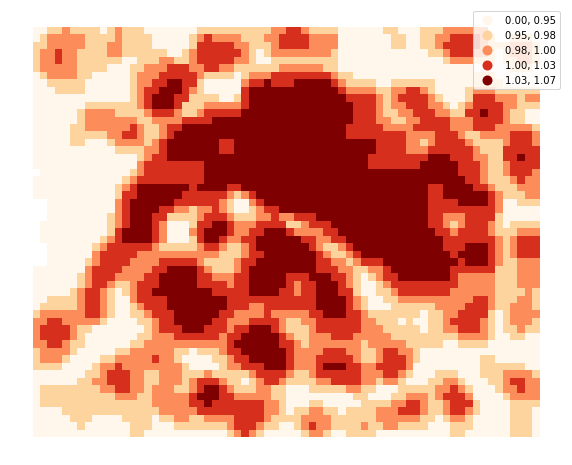

In [50]:
ax = scale_function.plot('D_2', scheme = 'quantiles', figsize=(10,10), legend=True, cmap='OrRd')
ax.axis(False)

In [32]:
def neighbors_near_point(df, weight, list_of_radius, xx, yy):
    df2 = df[(df.x > (xx - np.max(list_of_radius) - 5))&
             (df.x < (xx + np.max(list_of_radius) + 1005))&
             (df.y > (yy - np.max(list_of_radius) - 5))&
             (df.yy < (yy + np.max(list_of_radius) + 1005))].copy()

    neighbors = np.zeros([df2.shape[0],list_of_radius.size],dtype=np.float)
    for i, r in enumerate(list_of_radius):
        tree = KDTree(df2[['x', 'y']]) 
        neigh = RadiusNeighborsRegressor(radius=r)
        neigh.fit(df2[['x', 'y']],  df2[weight])
        neighbors[:,i] = tree.query_radius(df2[['x', 'y']], r= r, count_only=True) * neigh.predict(df2[['x', 'y']])
    result = pd.DataFrame(neighbors)
    result.columns = [str(t) for t in list_of_radius]
    temp = pd.concat([df2[['x', 'y', weight]].reset_index(), result], axis=1)
    temp = temp[(temp.x>=xx)&(temp.x<(xx+1000))&(temp.y>=yy)&(temp.y<(yy+1000))]
    return(temp)

In [ ]:
def neighbors_near_point(df, weight, list_of_radius, xx, yy):
    df2 = df[(df.x > (xx - np.max(list_of_radius) - 5))&
             (df.x < (xx + np.max(list_of_radius) + 1005))&
             (df.y > (yy - np.max(list_of_radius) - 5))&
             (df.yy < (yy + np.max(list_of_radius) + 1005))].copy()

    neighbors = np.zeros([df2.shape[0],list_of_radius.size],dtype=np.float)
    for i, r in enumerate(list_of_radius):
        tree = KDTree(df2[['x', 'y']]) 
        neigh = RadiusNeighborsRegressor(radius=r)
        neigh.fit(df2[['x', 'y']],  df2[weight])
        neighbors[:,i] = tree.query_radius(df2[['x', 'y']], r= r, count_only=True) * neigh.predict(df2[['x', 'y']])
    result = pd.DataFrame(neighbors)
    result.columns = [str(t) for t in list_of_radius]
    temp = pd.concat([df2[['x', 'y', weight]].reset_index(), result], axis=1)
    temp = temp[(temp.x>=xx)&(temp.x<(xx+1000))&(temp.y>=yy)&(temp.y<(yy+1000))]
    return(temp)

In [ ]:
toto = neighbors_near_point(df, 'height', list_of_radius, xx_yy.xx[0], xx_yy.yy[0])

In [27]:
toto

4

We reproject the neighbor from the european projection to the french projection :

In [7]:
transformer = Transformer.from_crs(3035, 2154)
neighbors.x, neighbors.y= transformer.transform(neighbors.y.values, neighbors.x.values)

In [29]:
neighbors['D2_400'] = neighbors['400'] * neighbors.Ind
neighbors['D2_800'] = neighbors['800'] * neighbors.Ind
neighbors['D2_1600'] = neighbors['1600'] * neighbors.Ind
neighbors['D2_3200'] = neighbors['3200'] * neighbors.Ind

neighbors['D0_400'] = neighbors['400']**(-1) * neighbors.Ind
neighbors['D0_800'] = neighbors['800']**(-1) * neighbors.Ind
neighbors['D0_1600'] = neighbors['1600']**(-1) * neighbors.Ind
neighbors['D0_3200'] = neighbors['3200']**(-1) * neighbors.Ind

neighbors['D1_400'] = np.log2(neighbors['400']) * neighbors.Ind
neighbors['D1_800'] = np.log2(neighbors['800']) * neighbors.Ind
neighbors['D1_1600'] = np.log2(neighbors['1600']) * neighbors.Ind
neighbors['D1_3200'] = np.log2(neighbors['3200']) * neighbors.Ind

Then we have just to smooth the neighbors to obtain the scale function. 

In [39]:
chem_data_dir = os.path.join(os.path.dirname(btbpy.__file__),'data')
chem_data_grid = os.path.join(chem_data_dir, 'fr_metro_grid1km.csv')
fr_1km = pd.read_csv(chem_data_grid)
scale_function = btbpy.kernelSmoothing(neighbors, '2154', 1000, 20000, fr_1km, verbose=False)

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [40]:
scale_function['D2_400'] = np.log2(scale_function['D2_400'] / scale_function.Ind)
scale_function['D2_800'] = np.log2(scale_function['D2_800'] / scale_function.Ind)
scale_function['D2_1600'] = np.log2(scale_function['D2_1600'] / scale_function.Ind)
scale_function['D2_3200'] = np.log2(scale_function['D2_3200'] / scale_function.Ind)

scale_function['D0_400'] = np.log2(scale_function['D0_400'] / scale_function.Ind)
scale_function['D0_800'] = np.log2(scale_function['D0_800'] / scale_function.Ind)
scale_function['D0_1600'] = np.log2(scale_function['D0_1600'] / scale_function.Ind)
scale_function['D0_3200'] = np.log2(scale_function['D0_3200'] / scale_function.Ind)

scale_function['D1_400'] = scale_function['D1_400'] / scale_function.Ind
scale_function['D1_800'] = scale_function['D1_800'] / scale_function.Ind
scale_function['D1_1600'] = scale_function['D1_1600'] / scale_function.Ind
scale_function['D1_3200'] = scale_function['D1_3200'] / scale_function.Ind

The correlation dimension is the slope of the curves of the log(scale fonction) versus log(radius).

In [41]:
Beta_radius = (np.log2(list_of_radius) - np.log2(list_of_radius).mean())/ np.log2(list_of_radius).var() / 4

In [42]:
D2_radius = ['D2_' + s  for s in list_of_radius.astype(str)]
D1_radius = ['D1_' + s  for s in list_of_radius.astype(str)]
D0_radius = ['D0_' + s  for s in list_of_radius.astype(str)]

In [43]:
scale_function['D_2'] =  scale_function[D2_radius].mul(Beta_radius).sum(1)
scale_function['D_1'] =  scale_function[D1_radius].mul(Beta_radius).sum(1)
scale_function['D_0'] =  -scale_function[D0_radius].mul(Beta_radius).sum(1)

In [44]:
scale_function[['D_0','D_1', 'D_2']]

,D_0,D_1,D_2
0,1.618648,1.310780,1.056116
1,1.623769,1.316764,1.059600
2,1.629220,1.322830,1.063156
3,1.662268,1.356263,1.084176
4,1.607071,1.309202,1.058101
...,...,...,...
548490,1.770601,1.410771,1.477262
548491,1.761169,1.457439,1.503610
548492,1.761761,1.443602,1.496274
548493,1.762073,1.427243,1.486564


We can display the map of the correlation dimension.

(42350.0, 1299650.0, 5996450.0, 7163550.0)

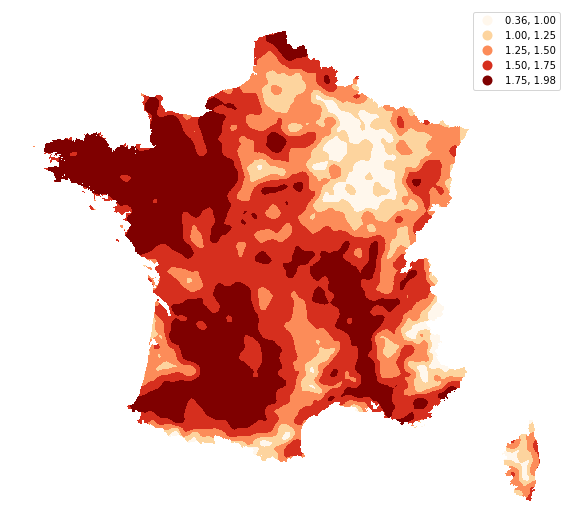

In [45]:
bins = [1, 1.25, 1.5, 1.75]
ax = scale_function.plot('D_0', scheme = 'User_Defined', classification_kwds={'bins':bins}, figsize=(10,10), legend=True, cmap='OrRd')
ax.axis(False)

Text(0.5, 1, 'D_2')

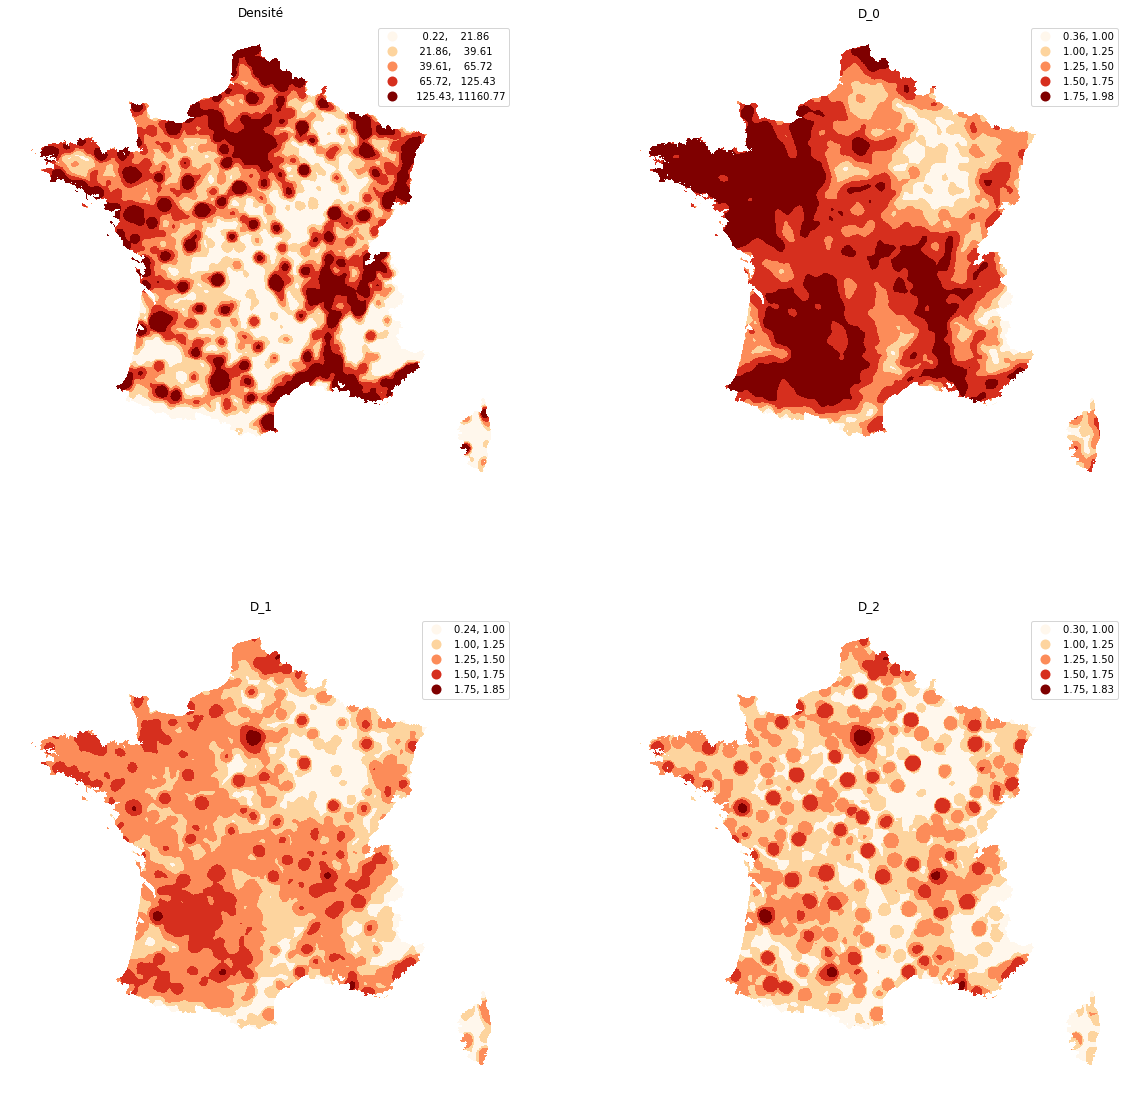

In [52]:
fig, axs = plt.subplots(ncols = 2, nrows= 2, figsize=(20,20))
scale_function.plot('Ind', scheme = 'Quantiles', figsize=(10,10), legend=True, cmap='OrRd', ax=axs[0,0])
axs[0,0].axis(False)
axs[0,0].set_title('Densité')
scale_function.plot('D_0', scheme = 'User_Defined', classification_kwds={'bins':bins}, figsize=(10,10), legend=True, cmap='OrRd', ax=axs[0,1])
axs[0,1].axis(False)
axs[0,1].set_title('D_0')
scale_function.plot('D_1', scheme = 'User_Defined', classification_kwds={'bins':bins}, figsize=(10,10), legend=True, cmap='OrRd', ax=axs[1,0])
axs[1,0].axis(False)
axs[1,0].set_title('D_1')
scale_function.plot('D_2', scheme = 'User_Defined', classification_kwds={'bins':bins}, figsize=(10,10), legend=True, cmap='OrRd', ax=axs[1,1])
axs[1,1].axis(False)
axs[1,1].set_title('D_2')

We can also compute the Box-counting dimension D0. To do that, we have to transform the neighbor.

In [55]:
neighbors_0 = neighbors.copy()
neighbors_0[list_of_radius.astype(str)] = neighbors_0[list_of_radius.astype(str)]**(-1) 
scale_function_0 = btbpy.kernelSmoothing(neighbors_0, '3035', 1000, 20000, fr_1km, verbose=False)

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Be carreful, the box-counting dimension is not the directely the slop but the opposite. 

In [57]:
scale_function_0['D_0'] = scale_function_0[list_of_radius.astype(str)].apply(lambda x :-LinearRegression().fit(np.log(list_of_radius).reshape(list_of_radius.size,1), np.log(x)).coef_[0] ,   axis=1 ) 

(42350.0, 1299650.0, 5996450.0, 7163550.0)

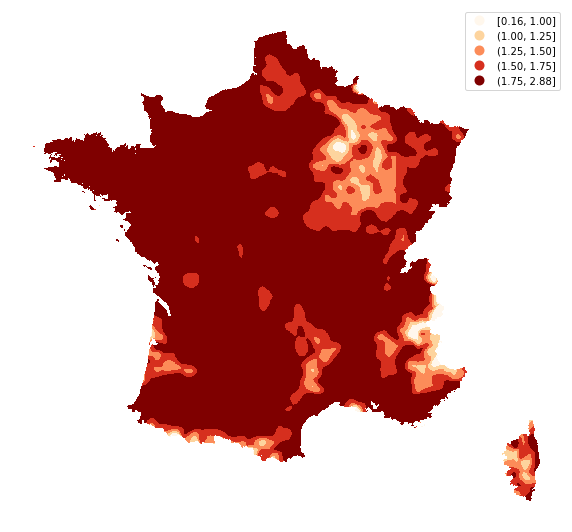

In [58]:
bins = [1, 1.25, 1.5, 1.75]
ax = scale_function_0.plot('D_0', scheme = 'User_Defined', classification_kwds={'bins':bins}, figsize=(10,10), legend=True, cmap='OrRd')
ax.axis(False)

Finally, we compute the Information Dimension (D_1)

In [59]:
neighbors_1 = neighbors.copy()
neighbors_1[list_of_radius.astype(str)] = np.log(neighbors_1[list_of_radius.astype(str)]) 
neighbors_1['cells'] = 1
scale_function_1 = btbpy.kernelSmoothing(neighbors_1, '3035', 1000, 20000, fr_1km, verbose=False)

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [60]:
scale_function_1['D_1'] = scale_function_1[list_of_radius.astype(str)].apply(lambda x :LinearRegression().fit(np.log(list_of_radius).reshape(list_of_radius.size,1), x).coef_[0] ,   axis=1 ) 
scale_function_1['D_1'] = scale_function_1['D_1'] / scale_function_1['cells']

(42350.0, 1299650.0, 5996450.0, 7163550.0)

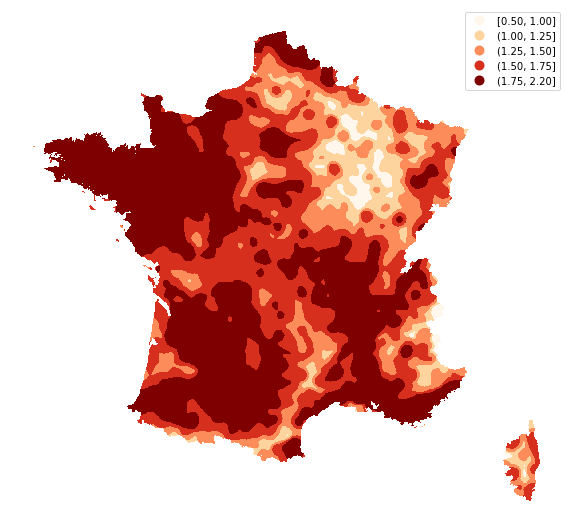

In [61]:
bins = [1, 1.25, 1.5, 1.75]
ax = scale_function_1.plot('D_1', scheme = 'User_Defined', classification_kwds={'bins':bins}, figsize=(10,10), legend=True, cmap='OrRd')
ax.axis(False)